In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
%matplotlib inline

sns.set(style='darkgrid', palette="muted", font="serif", font_scale=1)
       

In [2]:
# URL load
# URL for other file downloads:
# https://github.com/llimllib/bostonmarathon/tree/master/results/2013
url = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])

In [3]:
# length of df
len(df)

16164

# Section I: Data Cleaning

In [4]:
df.dtypes

age            int64
name          object
division       int64
10k           object
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k           object
5k            object
genderdiv      int64
20k           object
35k           object
city          object
40k           object
dtype: object

In [5]:
df.sample(1)

,age,name,division,10k,gender,half,official,bib,ctz,country,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
25k,,,,,,,,,,,,,,,,,,,,
104.73,33,"Girard, Mathieu",1511,41.75,M,88.17,181.02,4546,NaN,CAN,2268,6.92,QC,126.48,20.90,2119,83.58,149.28,Laval,171.30


## Convert types from strings to integers

In [6]:
df['age'] = df['age'].astype(str).astype(int)

In [7]:
df['division'] = df['division'].astype(str).astype(int)

In [8]:
df['10k'] = df['10k'].astype(float, errors='ignore')

In [9]:
df['half'] = df['half'].astype(str).astype(float, errors='ignore')

In [10]:
df['official'] = df['official'].astype(str).astype(float, errors='ignore')

In [11]:
df['bib'] = df['bib'].astype(str).astype(int, errors='ignore')

In [12]:
df['overall'] = df['overall'].astype(str).astype(int)

In [13]:
df['pace'] = df['pace'].astype(str).astype(float, errors='ignore')

In [14]:
df['genderdiv'] = df['genderdiv'].astype(str).astype(int, errors='ignore')

In [15]:
df['30k'] = df['30k'].astype(str).astype(float, errors='ignore')

In [16]:
df['5k'] = df['5k'].astype(str).astype(float, errors='ignore')

In [17]:
df['20k'] = df['20k'].astype(str).astype(float, errors='ignore')

In [18]:
df['35k'] = df['35k'].astype(str).astype(float, errors='ignore')

In [19]:
df['40k'] = df['40k'].astype(str).astype(float, errors='ignore')

## Downcast columns by type for improve memory usage

In [20]:
df['age'] = pd.to_numeric(df['age'], errors='coerce', downcast='integer')

In [21]:
df['division'] = pd.to_numeric(df['division'], errors='coerce', downcast='integer')

In [22]:
df['10k'] = pd.to_numeric(df['10k'], errors='coerce', downcast='float')

In [23]:
df['half'] = pd.to_numeric(df['half'], errors='coerce', downcast='float')

In [24]:
df['official'] = pd.to_numeric(df['official'], errors='coerce', downcast='float')

In [25]:
df['bib'] = pd.to_numeric(df['bib'], errors='coerce', downcast='integer')

In [26]:
df['overall'] = pd.to_numeric(df['overall'], errors='coerce', downcast='integer')

In [27]:
df['pace'] = pd.to_numeric(df['pace'], errors='ignore', downcast='float')

In [28]:
df['30k'] = pd.to_numeric(df['30k'], errors='coerce', downcast='float')

In [29]:
df['5k'] = pd.to_numeric(df['5k'], errors='coerce', downcast='float')

In [30]:
df['genderdiv'] = pd.to_numeric(df['genderdiv'], errors='coerce', downcast='integer')

In [31]:
df['20k'] = pd.to_numeric(df['20k'], errors='coerce', downcast='float')

In [32]:
df['35k'] = pd.to_numeric(df['35k'], errors='coerce', downcast='float')

In [33]:
df['40k'] = pd.to_numeric(df['40k'], errors='coerce', downcast='float')

In [34]:
df.dtypes

age             int8
name          object
division       int16
10k          float32
gender        object
half         float32
official     float32
bib          float64
ctz           object
country       object
overall        int16
pace         float32
state         object
30k          float32
5k           float32
genderdiv      int16
20k          float32
35k          float32
city          object
40k          float32
dtype: object

## Identifying NaN's

In [35]:
# counts the number of NaN values in the columns
df.isnull().sum()

age              0
name             0
division         0
10k             26
gender           0
half            16
official         0
bib             53
ctz          15407
country          0
overall          0
pace             0
state         1463
30k             17
5k              66
genderdiv        0
20k             17
35k             21
city             1
40k             17
dtype: int64

## Considering how Country is a good enough identifier for a runner, we can drop ctz, state, and city. 

In [36]:
df.drop(['ctz', 'state', 'city', 'bib'], 1, inplace=True)

In [37]:
df_length = len(df)
df_length

16164

In [38]:
# drop rows with NaN's
df = df.dropna(axis=0)

In [39]:
# confirmation all rows with NaN's are dropped
df.isnull().sum()

age          0
name         0
division     0
10k          0
gender       0
half         0
official     0
country      0
overall      0
pace         0
30k          0
5k           0
genderdiv    0
20k          0
35k          0
40k          0
dtype: int64

In [40]:
# creating and printing the variable for the number of rides in the dataset without NaN's
no_nans = len(df)
print(no_nans)

16062


## Even when dropping all the NaN's, it was less than 1%.

In [41]:
nan_df_percent = no_nans / df_length
print("There are {} rides without NaN values out of the original {}, which is equal to {}."
      .format(no_nans, df_length, nan_df_percent))

There are 16062 rides without NaN values out of the original 16164, which is equal to 0.9936896807720861.


## Create new column to represent category codes for Gender and Country

In [42]:
# new column copy of country to be coded
df['country_code'] = df.country
df.country_code = df.country_code.astype('category')
df.country_code = df.country_code.cat.codes

df['gender_code'] = df.gender
df.gender_code = df.gender_code.astype('category')
df.gender_code = df.gender_code.cat.codes

In [43]:
# confirm types and size
df[['country_code', 'gender_code']].dtypes

country_code    int8
gender_code     int8
dtype: object

## Finally, let's reorder the columns so they can be more easily read

Before

In [44]:
df.head(1)

,age,name,division,10k,gender,half,official,country,overall,pace,30k,5k,genderdiv,20k,35k,40k,country_code,gender_code
25k,,,,,,,,,,,,,,,,,,
49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.900002,CAN,9,3.47,62.07,8.9,9,38.799999,74.730003,85.550003,9,1


After

In [45]:
df = df[['country', 'country_code', 'name', 'age', 'gender', 
         'gender_code', 'genderdiv', 'division', 'overall', 'pace', 
         'official', '5k', '10k', '20k', 'half', '30k', '35k','40k']]

In [46]:
df.head(1)

,country,country_code,name,age,gender,gender_code,genderdiv,division,overall,pace,official,5k,10k,20k,half,30k,35k,40k
25k,,,,,,,,,,,,,,,,,,
49.87,CAN,9,"Cassidy, Josh R.",28,M,1,9,9,9,3.47,90.900002,8.9,18.18,38.799999,40.93,62.07,74.730003,85.550003


# Section II: Exploration

In [47]:
# create new df for analysis
nation = df[['country','official','age','overall', 'gender_code']]
nation.head()

,country,official,age,overall,gender_code
25k,,,,,
49.87,CAN,90.900002,28,9,1
77.27,KEN,132.500000,30,5,1
77.23,ETH,130.369995,23,1,1
50.50,AUS,88.430000,32,5,1
48.75,JPN,87.220001,39,3,1


# Evaluating the Runners

## There are more Male runners than there are female (F=0, M=1). 
## Out of 16,009 runners in this dataset, 59.7% are men and 41.3% are women

In [48]:
nation.groupby('gender_code').count()

,country,official,age,overall
gender_code,,,,
0,6448,6448,6448,6448
1,9614,9614,9614,9614


## There is also an imbalance between men and women with finishing places...

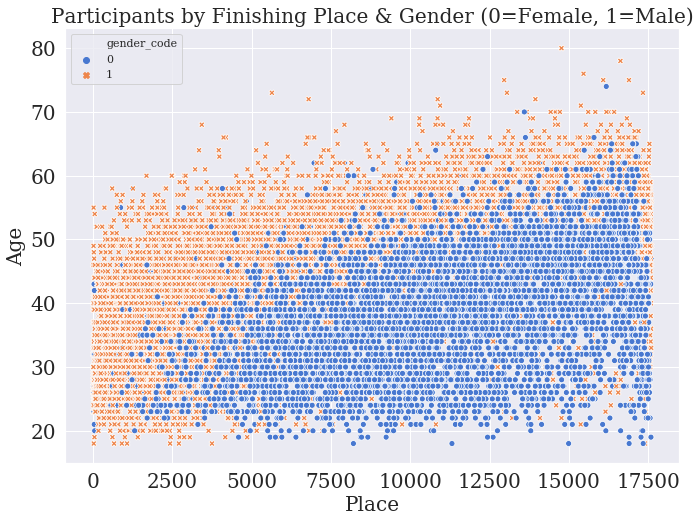

In [49]:
plt.figure(figsize=(11,8))
markers = {0: "o", 1: "X"}
ax_gender = sns.scatterplot(x="overall", y="age", hue="gender_code", markers=markers,
                            style="gender_code", data=nation, ci = 95, legend="full")
plt.title('Participants by Finishing Place & Gender (0=Female, 1=Male)', fontsize=20)
ax_gender.set_ylabel("Age", fontsize=20)
ax_gender.set_xlabel("Place", fontsize=20)
ax_gender.tick_params(labelsize=20)

plt.show()

## As well as their finishing times

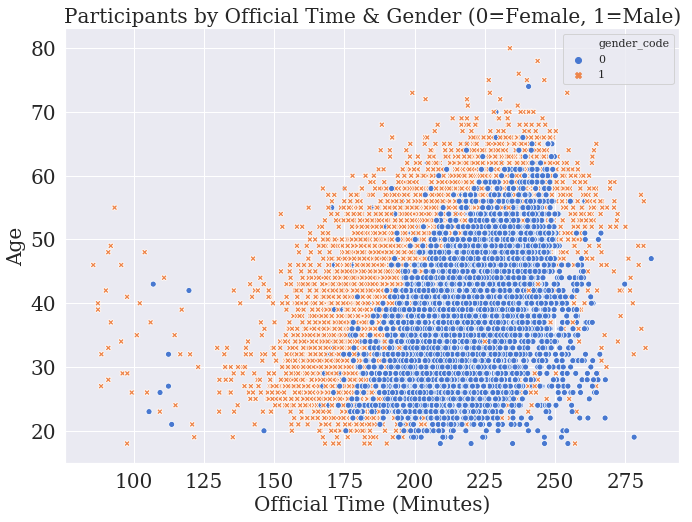

In [50]:
plt.figure(figsize=(11,8))
markers = {0: "o", 1: "X"}
ax_gender = sns.scatterplot(x="official", y="age", hue="gender_code", markers=markers,
                            style="gender_code", data=nation, ci = 95, legend="full")
plt.title('Participants by Official Time & Gender (0=Female, 1=Male)', fontsize=20)
ax_gender.set_ylabel("Age", fontsize=20)
ax_gender.set_xlabel("Official Time (Minutes)", fontsize=20)
ax_gender.tick_params(labelsize=20)

plt.show()

## Women have more even distribution of runners by age whereas men are more heavily weighted towards middle-age runners.

In [51]:
# create two df's for each gender
males_only = nation.loc[nation['gender_code'] == 1]
females_only = nation.loc[nation['gender_code'] == 0]

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


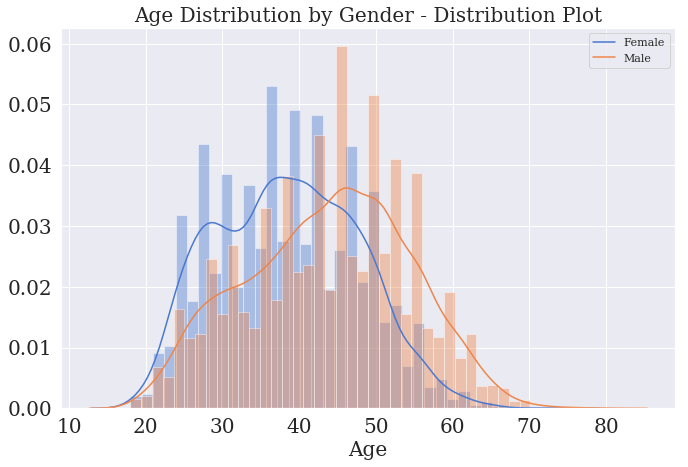

In [52]:
plt.figure(figsize=(11,7))
ax1 = sns.distplot(females_only.age, bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "Female"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None,
                  )

ax2 = sns.distplot(males_only.age, bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "Male"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
plt.title('Age Distribution by Gender - Distribution Plot', fontsize=20)
ax1.set_xlabel("Age", fontsize=20)
ax1.tick_params(labelsize=20)
plt.show()

## The dotted lines in the figures represent the Quartiles of the runners by gender.
## The first quartile among women ends at 31 followed by men at 36.
## There is ~6 year gap between them continues until the women's fourth quartile begins at 46 where men's final quartile begins at 51.

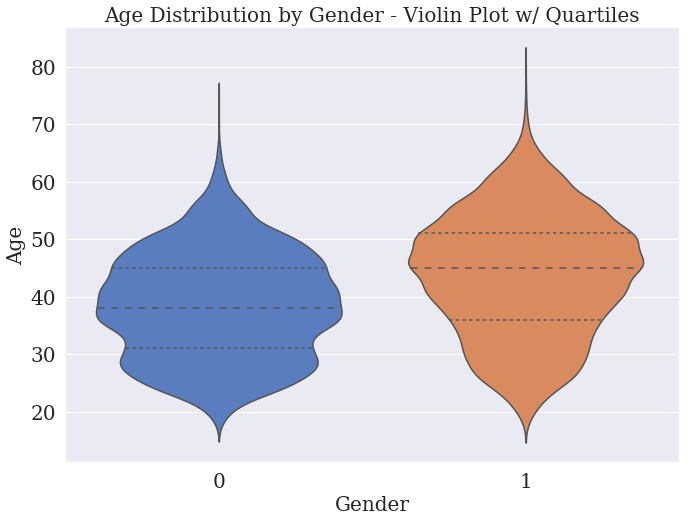

In [53]:
plt.figure(figsize=(11,8))
markers = {0: "o", 1: "X"}
ax_gender3 = sns.violinplot(x='gender_code', y='age', hue=None, data=nation, order=None, hue_order=None, 
                        bw='scott', cut=2, scale='area', scale_hue=True, gridsize=100, width=0.8, 
                        inner='quartile', split=True, dodge=True, orient=None, linewidth=None, 
                        color=None, palette=None, saturation=0.75, ax=None)
plt.title('Age Distribution by Gender - Violin Plot w/ Quartiles', fontsize=20)
ax_gender3.set_ylabel("Age", fontsize=20)
ax_gender3.set_xlabel("Gender", fontsize=20)
ax_gender3.tick_params(labelsize=20)


plt.show()

## Evaluating the Race

In [54]:
df.head(1)

,country,country_code,name,age,gender,gender_code,genderdiv,division,overall,pace,official,5k,10k,20k,half,30k,35k,40k
25k,,,,,,,,,,,,,,,,,,
49.87,CAN,9,"Cassidy, Josh R.",28,M,1,9,9,9,3.47,90.900002,8.9,18.18,38.799999,40.93,62.07,74.730003,85.550003


In [55]:
# new features that measure the difference between the different checkpoints in the race
# Marathons are ~42 kilometers total so the "half" is ~ 21 kilometers.
df['delta0-5k'] = df['5k']
df['delta5k-10k'] = (df['10k'] - df['5k'])
df['delta10k-20k'] = (df['20k'] - df['10k'])
df['delta20k-half'] = (df['half'] - df['20k'])
df['delta_half-30k'] = (df['30k'] - df['half'])
df['delta30k-35k'] = (df['35k'] - df['30k'])
df['delta35k-40k'] = (df['40k'] - df['35k'])
df['delta40k-official'] = (df['official'] - df['40k'])

## Interestingly, the runners are remarkably consistent, with the last two checkpoints taking only slightly longer than the first two checkpoints

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


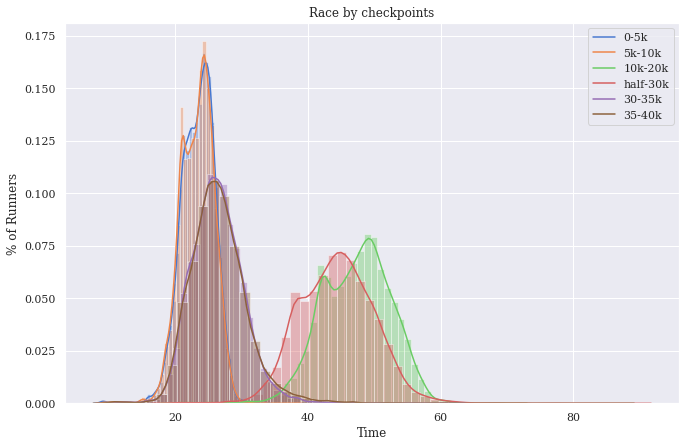

In [56]:
plt.figure(figsize=(11,7))
delta1 = sns.distplot(df['delta0-5k'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "0-5k"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
delta2 = sns.distplot(df['delta5k-10k'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "5k-10k"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
delta3 = sns.distplot(df['delta10k-20k'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "10k-20k"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
#delta4 = sns.distplot(df['delta20k-half'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   #hist_kws=None, kde_kws={"label": "20k-half"}, rug_kws=None, fit_kws=None, color=None, 
                   #vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
delta5 = sns.distplot(df['delta_half-30k'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "half-30k"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
delta6 = sns.distplot(df['delta30k-35k'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "30-35k"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
delta7 = sns.distplot(df['delta35k-40k'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   hist_kws=None, kde_kws={"label": "35-40k"}, rug_kws=None, fit_kws=None, color=None, 
                   vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
#delta8 = sns.distplot(df['delta40k-official'], bins=None, hist=True, kde=True, rug=False, fit=None, 
                   #hist_kws=None, kde_kws={"label": "40k-official"}, rug_kws=None, fit_kws=None, color=None, 
                   #vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
plt.title('Race by checkpoints')
delta7.set_xlabel("Time")
delta7.set_ylabel("% of Runners")
plt.show()

# Section III: Principal Component Analysis (PCA)

In [57]:
df.head(1)

,country,country_code,name,age,gender,gender_code,genderdiv,division,overall,pace,...,35k,40k,delta0-5k,delta5k-10k,delta10k-20k,delta20k-half,delta_half-30k,delta30k-35k,delta35k-40k,delta40k-official
25k,,,,,,,,,,,,,,,,,,,,,
49.87,CAN,9,"Cassidy, Josh R.",28,M,1,9,9,9,3.47,...,74.730003,85.550003,8.9,9.280001,20.619999,2.130001,21.139999,12.660004,10.82,5.349998


In [58]:
males_only.head(1)

,country,official,age,overall,gender_code
25k,,,,,
49.87,CAN,90.900002,28,9,1


In [59]:
def doPCA():
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(males_only.drop('country', 1))

In [60]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components=2)
pca.fit(males_only.drop('country', 1))  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
print("Variance Ratio: {}".format(pca.explained_variance_ratio_))  
print("Singular Values: {}".format(pca.singular_values_))

Variance Ratio: [9.99995451e-01 2.93898081e-06]
Singular Values: [484874.19074613    831.24382195]


In [62]:
pca_gender_checkpoints?

Object `pca_gender_checkpoints` not found.


In [63]:
df.head(1)

,country,country_code,name,age,gender,gender_code,genderdiv,division,overall,pace,...,35k,40k,delta0-5k,delta5k-10k,delta10k-20k,delta20k-half,delta_half-30k,delta30k-35k,delta35k-40k,delta40k-official
25k,,,,,,,,,,,,,,,,,,,,,
49.87,CAN,9,"Cassidy, Josh R.",28,M,1,9,9,9,3.47,...,74.730003,85.550003,8.9,9.280001,20.619999,2.130001,21.139999,12.660004,10.82,5.349998


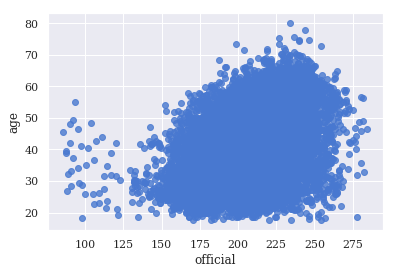

In [64]:
pca_gender_checkpoints = df[[
    'delta0-5k','delta5k-10k','delta10k-20k', 'delta20k-half', 'delta_half-30k', 
    'delta30k-35k', 'delta35k-40k', 'delta40k-official', 'official', 'age']].dropna()

t = sns.regplot(
    'official',
    'age',
    pca_gender_checkpoints,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False)

In [65]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(pca_gender_checkpoints)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00006226 0.97287993 0.94260085 0.86767463 0.81336421 0.66487817
  0.54162615 0.53584194 0.87315749 0.36649338]
 [0.97287993 1.00006226 0.97053844 0.89162506 0.84539942 0.69454401
  0.56441881 0.55632024 0.8980108  0.37451164]
 [0.94260085 0.97053844 1.00006226 0.91669389 0.90180124 0.7542405
  0.61354302 0.5970966  0.93404789 0.38250663]
 [0.86767463 0.89162506 0.91669389 1.00006226 0.86880493 0.74047075
  0.61304397 0.59649647 0.89192351 0.35721852]
 [0.81336421 0.84539942 0.90180124 0.86880493 1.00006226 0.89020654
  0.74917505 0.70463201 0.96362334 0.34481644]
 [0.66487817 0.69454401 0.7542405  0.74047075 0.89020654 1.00006226
  0.85969858 0.7909743  0.91619156 0.30614637]
 [0.54162615 0.56441881 0.61354302 0.61304397 0.74917505 0.85969858
  1.00006226 0.86686656 0.83114358 0.25054461]
 [0.53584194 0.55632024 0.5970966  0.59649647 0.70463201 0.7909743
  0.86686656 1.00006226 0.78958703 0.3077174 ]
 [0.87315749 0.8980108  0.93404789 0.89192351 0.96362334 0.916

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int8, float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [66]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

In [67]:
eig_val_cov.shape

(10,)

In [68]:
eig_vec_cov.shape

(10, 10)

In [69]:
eig_val_cov[0] / eig_val_cov.sum()

0.7511600251672819

In [70]:
eig_val_cov[1] / eig_val_cov.sum()

0.10614524403568859

In [71]:
eig_vec_cov[0]

array([-0.32648447, -0.34222969,  0.13811846,  0.32693551, -0.33414137,
       -0.09516149, -0.32622994,  0.60096604, -0.24795257, -0.02346066])

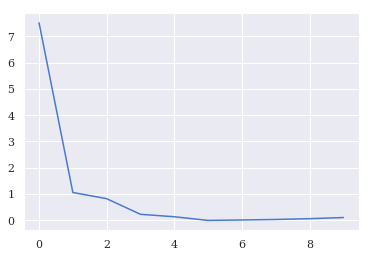

In [72]:
#scree
plt.plot(eig_val_cov)
plt.show()

/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


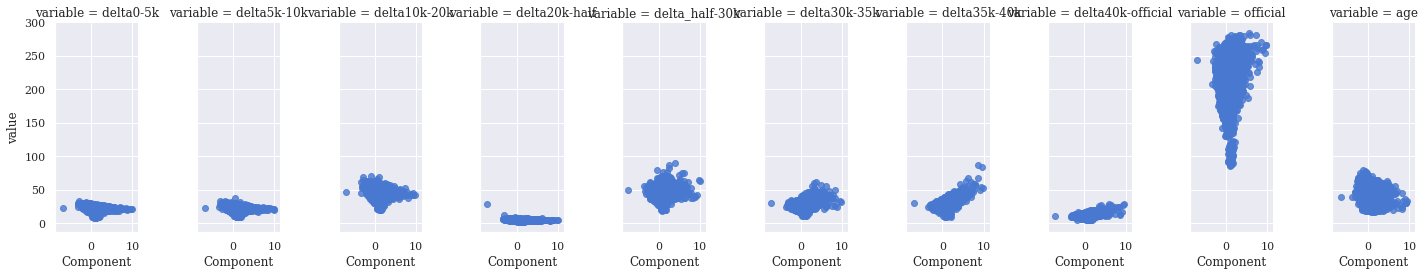

In [73]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 1]

# Transform X into Y.
Y = P.T.dot(Xt)

# Combine X and Y for plotting purposes.
data_to_plot = pca_gender_checkpoints[['delta0-5k','delta5k-10k','delta10k-20k', 
        'delta20k-half', 'delta_half-30k', 'delta30k-35k', 'delta35k-40k',
        'delta40k-official', 'official', 'age']]
data_to_plot['Component'] = Y
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", size=4, aspect=.5)
g = g.map(
    sns.regplot,
    "Component",
    "value",
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
plt.show()

In [74]:
# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov #[:, i].reshape(10,10).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-3.26484465e-01 -3.42229690e-01  1.38118458e-01  3.26935510e-01
  -3.34141372e-01 -9.51614930e-02 -3.26229942e-01  6.00966035e-01
  -2.47952572e-01 -2.34606636e-02]
 [-3.34668502e-01 -3.24110606e-01  1.34611369e-01  2.33679941e-01
  -2.26082169e-01 -9.57289237e-02  7.57482358e-01 -2.72071996e-01
  -4.46709018e-02  1.21415373e-02]
 [-3.45086808e-01 -2.56383298e-01  1.18390186e-01  2.37364960e-02
  -5.24479542e-02 -1.98394673e-01 -5.46305952e-01 -6.32715315e-01
   2.29669882e-01  8.34547189e-02]
 [-3.33457313e-01 -2.05250546e-01  1.16475611e-01 -9.19993999e-02
   7.92204686e-01 -2.35387303e-02  2.69658648e-02  7.55537999e-02
  -2.08748366e-01 -3.82745640e-01]
 [-3.47744731e-01  2.40759878e-02  7.67825394e-02 -4.38284773e-01
   6.38152617e-02 -2.16008629e-01  1.37547588e-01  3.82158555e-01
   6.01301260e-01  3.21317642e-01]
 [-3.26285483e-01  3.08019657e-01 -7.14680386e-03 -5.15448912e-01
  -1.82204035e-01 -1.50988625e-01 -6.19766173e-03 -1.08616442e-01
  -6.50208910e-01

## Or we can do it using ScikitLearn

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.75116003 0.10614524 0.08260361 0.02318717]


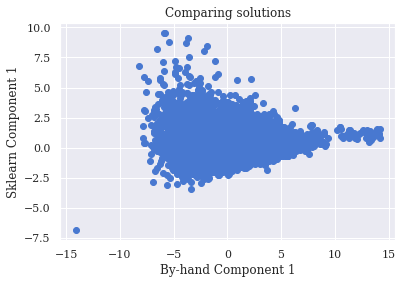

In [75]:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# Compare the sklearn solution my manual one – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

# Section IV: Clustering

In [76]:
# import libraries
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

## Preparing Clusters

In [77]:
df.head(1)

,country,country_code,name,age,gender,gender_code,genderdiv,division,overall,pace,...,35k,40k,delta0-5k,delta5k-10k,delta10k-20k,delta20k-half,delta_half-30k,delta30k-35k,delta35k-40k,delta40k-official
25k,,,,,,,,,,,,,,,,,,,,,
49.87,CAN,9,"Cassidy, Josh R.",28,M,1,9,9,9,3.47,...,74.730003,85.550003,8.9,9.280001,20.619999,2.130001,21.139999,12.660004,10.82,5.349998


In [78]:
df.drop(['name', 'country', 'gender'],axis=1, inplace=True)

In [79]:
data_norm = normalize(df)

In [80]:
X = df.drop(['overall'], 1)
X = pd.get_dummies(df, columns=['gender_code', 'country_code'])
y = df.overall

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=36)

In [81]:
df.head(1)

,country_code,age,gender_code,genderdiv,division,overall,pace,official,5k,10k,...,35k,40k,delta0-5k,delta5k-10k,delta10k-20k,delta20k-half,delta_half-30k,delta30k-35k,delta35k-40k,delta40k-official
25k,,,,,,,,,,,,,,,,,,,,,
49.87,9,28,1,9,9,9,3.47,90.900002,8.9,18.18,...,74.730003,85.550003,8.9,9.280001,20.619999,2.130001,21.139999,12.660004,10.82,5.349998


In [92]:
df.shape

(16062, 23)

In [82]:
# Normalize
X_norm = normalize(df)

# Data frame to store features and predicted cluster memberships.
ypred = df

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=36)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=36)

In [84]:
Xdf = [X1,X2,X3,X4]

In [85]:
clusters = [2,3,4,5,6,7,8,9]
for i in clusters:
    print("Number of defined clusters: {}".format(i))
    for j in Xdf:
        model = KMeans(n_clusters=i, random_state=None).fit(j)
        labels = model.labels_
        print(metrics.silhouette_score(j, labels, metric='euclidean'))

Number of defined clusters: 2
0.5112440677787979
0.5167796990102164
0.5163523557306492
0.5151098353525033
Number of defined clusters: 3
0.5979790670298123
0.6002027566911067
0.5952950487830561
0.5950520974539042
Number of defined clusters: 4
0.6350074724485885
0.6328469876122509
0.6272922217802114
0.6291883050462206
Number of defined clusters: 5
0.63595684556661
0.5407202370518284
0.5375533435290303
0.6306476295408799
Number of defined clusters: 6
0.5604297552822516
0.5382642766263116
0.5442422153520753
0.5429660112464656
Number of defined clusters: 7
0.602220966925114
0.5993301885822501
0.603994719928768
0.47320029939832586
Number of defined clusters: 8
0.5381272250301856
0.5315887384751232
0.5300409616462128
0.535175901859436
Number of defined clusters: 9
0.5246132406582693
0.5250594662600331
0.5181041242763467
0.5216281652415192


In [86]:
labels.shape

(4016,)

In [88]:
X1.shape

(4015, 23)

In [89]:
X2.shape

(4016, 23)

In [90]:
X3.shape

(4015, 23)

In [91]:
X4.shape

(4016, 23)

## Mean-shift Clustering

In [99]:
# all data
for i in Xdf:    
    bandwidth = estimate_bandwidth(i, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(i)    
    labels = ms.labels_   
    # Count our clusters.
    n_clusters_ = len(np.unique(labels)) 
    print("Number of estimated clusters: {}".format(n_clusters_)) 
    print(metrics.silhouette_score(i, labels, metric='euclidean'))

Number of estimated clusters: 3
0.4445595176922355
Number of estimated clusters: 3
0.7071946175661421
Number of estimated clusters: 4
0.6137278872481863
Number of estimated clusters: 4
0.6936228906316219


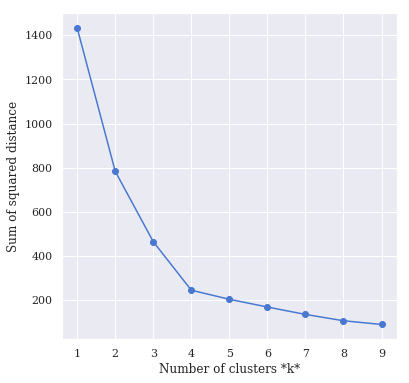

In [89]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_norm)
    labels = km.labels_
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [100]:
labels.shape

(4015,)

## 3 and 4 clusters seem to perform best

## Spectral Clustering

In [97]:
# Since the scree charts is favoring fewer clusters I'll focus on those.
clusters = [2,3,4]
for i in clusters:
    print("Number of defined clusters: {}".format(i))
    for j in Xdf:
        sc = SpectralClustering(n_clusters=i)
        sc.fit(j)
        #labels = sc.labels_
        #print(metrics.silhouette_score(j, labels, metric='euclidean'))

 

Number of defined clusters: 2


/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/Users/jakegrosek/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


KeyboardInterrupt: 

In [102]:
labels.shape

(4015,)

## Affinity Cluster

In [103]:
for j in Xdf:
    af = AffinityPropagation(damping=.9).fit(j)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_2_ = len(cluster_centers_indices)
    labels_2 = af.labels_
    print('Estimated number of clusters: {}'.format(n_clusters_2_))
    print(metrics.silhouette_score(j, labels_2, metric='euclidean'))

Estimated number of clusters: 42
0.47073828319451416
Estimated number of clusters: 49
0.4742001404544618
Estimated number of clusters: 28
0.4877999694632614
Estimated number of clusters: 29
0.4769303889365673


## This model is the outlier of the four models.  It prefers a much higher number of clusters that have lower scores than the other three models so I'll use a smaller number of clusters for evaluation.

In [104]:
labels.shape

(4015,)

In [93]:
np.reshape(Xdf, 16062)

ValueError: cannot reshape array of size 4 into shape (16062,)

In [107]:
df['label'] = labels

ValueError: Length of values does not match length of index